In [113]:
! . .venv/bin/activate
! sstat -j $SLURM_JOB_ID 

JobID         MaxVMSize  MaxVMSizeNode  MaxVMSizeTask  AveVMSize     MaxRSS MaxRSSNode MaxRSSTask     AveRSS MaxPages MaxPagesNode   MaxPagesTask   AvePages     MinCPU MinCPUNode MinCPUTask     AveCPU   NTasks AveCPUFreq ReqCPUFreqMin ReqCPUFreqMax ReqCPUFreqGov ConsumedEnergy  MaxDiskRead MaxDiskReadNode MaxDiskReadTask  AveDiskRead MaxDiskWrite MaxDiskWriteNode MaxDiskWriteTask AveDiskWrite TRESUsageInAve TRESUsageInMax TRESUsageInMaxNode TRESUsageInMaxTask TRESUsageInMin TRESUsageInMinNode TRESUsageInMinTask TRESUsageInTot TRESUsageOutAve TRESUsageOutMax TRESUsageOutMaxNode TRESUsageOutMaxTask TRESUsageOutMin TRESUsageOutMinNode TRESUsageOutMinTask TRESUsageOutTot 
------------ ---------- -------------- -------------- ---------- ---------- ---------- ---------- ---------- -------- ------------ -------------- ---------- ---------- ---------- ---------- ---------- -------- ---------- ------------- ------------- ------------- -------------- ------------ --------------- --------------- 

In [114]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

In [115]:
project_dir = "../../../"
games = pd.read_csv(f'{project_dir}/games.csv')
plays = pd.read_csv(f'{project_dir}/plays.csv')
players = pd.read_csv(f'{project_dir}/players.csv')
tracking_df = pd.read_csv(f'{project_dir}/tracking_week_2.csv')
player_play = pd.read_csv(f'{project_dir}/player_play.csv')

# Get Plays With Pressure

In [116]:
# Filter for plays where any defensive player caused pressure
# Select only rows where 'causedPressure' is True, and keep unique gameId-playId pairs
plays_with_pressure = player_play[player_play['causedPressure'] == True][['gameId', 'playId']].drop_duplicates()

# Merge plays with plays_with_pressure to create a labeled dataset
# Add a new column 'causedPressure' to indicate if pressure was caused on a play
# Use a left merge and set '_merge' column to check if the play exists in plays_with_pressure
plays['causedPressure'] = plays.merge(plays_with_pressure, on=['gameId', 'playId'], how='left', indicator=True)['_merge'] == 'both'
plays['causedPressure'] = plays['causedPressure'].astype(int)  # Convert boolean values to 0/1 

# Drop duplicates to ensure unique plays
# Keep only one record per gameId-playId pair
dataset = plays.drop_duplicates(subset=['gameId', 'playId'])

# Filter out irrelevant plays

[2.99  1.836 2.236 ... 2.242 1.766 1.937]
['0-1', '1-2', '2-3', '3-4', '4-5', '5-6', '6-7', '7-8', '8-9', '9-10']


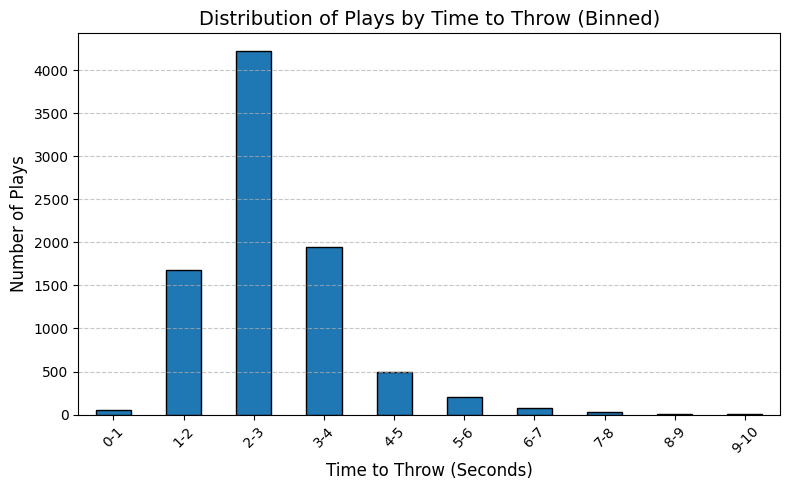

In [117]:
# Print out the unique values for teh timeToThrow column
print(plays["timeToThrow"].unique())

# Define bins for each second
bins = range(0, int(plays["timeToThrow"].max()) + 2)  # Adding 2 to include the upper boundary
labels = [f"{i}-{i+1}" for i in bins[:-1]]  # Labels for each bin
print(labels)

# Bin the data
plays["timeToThrow_binned"] = pd.cut(plays["timeToThrow"], bins=bins, labels=labels, right=False)

# Count the distribution
distribution = plays["timeToThrow_binned"].value_counts(sort=False)

# Plot the distribution
plt.figure(figsize=(8, 5))
distribution.plot(kind="bar", edgecolor="black")
plt.title("Distribution of Plays by Time to Throw (Binned)", fontsize=14)
plt.xlabel("Time to Throw (Seconds)", fontsize=12)
plt.ylabel("Number of Plays", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [118]:
# Filter the distribution for bins "4-5" and larger
filtered_bins = distribution[distribution.index >= "4-5"]

# Print the total count of plays in these bins
count_in_filtered_bins = filtered_bins.sum()
print(f"There are {count_in_filtered_bins} plays where the QB holds the ball for more than 4 seconds")

There are 814 plays where the QB holds the ball for more than 4 seconds


In [119]:
# # Now filter these plays out
# filtered_plays = plays[plays["timeToThrow_binned"] >= "4-5"]

# # Get the gameId and playId of these plays
# filtered_game_play_ids = filtered_plays[["gameId", "playId"]]

# # Filter out these plays in the other dataset
# filtered_dataset = dataset.merge(filtered_game_play_ids, on=["gameId", "playId"], how="outer", indicator=True)
# dataset = filtered_dataset[filtered_dataset["_merge"] == "left_only"].drop(columns=["_merge"])

# Feature 1: Offensive Formation

In [120]:
# Feature 1: offenseFormation
unique_offense_formations = dataset['offenseFormation'].unique()
print(unique_offense_formations)

# One hot encode the offensive formation
one_hot_encoded_offense_formations = pd.get_dummies(dataset['offenseFormation'], prefix='formation')
ml_dataset = pd.concat([dataset, one_hot_encoded_offense_formations], axis=1) 

# Print the new offensive formations
offense_cols = one_hot_encoded_offense_formations.columns
print(ml_dataset[offense_cols].head())

#Print how many are nan 
print(ml_dataset['offenseFormation'].isnull().sum())




['EMPTY' 'SHOTGUN' 'PISTOL' 'SINGLEBACK' nan 'JUMBO' 'I_FORM' 'WILDCAT']
   formation_EMPTY  formation_I_FORM  formation_JUMBO  formation_PISTOL  \
0             True             False            False             False   
1             True             False            False             False   
2            False             False            False             False   
3            False             False            False             False   
4            False             False            False              True   

   formation_SHOTGUN  formation_SINGLEBACK  formation_WILDCAT  
0              False                 False              False  
1              False                 False              False  
2               True                 False              False  
3               True                 False              False  
4              False                 False              False  
188


# Feature 2: Defensive Formation

In [121]:
# One hot encode the defensive formation
one_hot_encoded_defense_formations = pd.get_dummies(dataset['pff_passCoverage'], prefix='formation')
ml_dataset = pd.concat([ml_dataset, one_hot_encoded_defense_formations], axis=1)

# Get the new defensive formations columns
defense_cols = one_hot_encoded_defense_formations.columns
print(ml_dataset[defense_cols].head())

# num_miscellaneous = ml_dataset['formation_Miscellaneous'].sum()
# print(f"Number of rows with formation_Miscellaneous: {num_miscellaneous}")


   formation_2-Man  formation_Bracket  formation_Cover 6-Left  \
0            False              False                   False   
1            False              False                   False   
2            False              False                   False   
3            False              False                   False   
4            False              False                   False   

   formation_Cover-0  formation_Cover-1  formation_Cover-1 Double  \
0              False              False                     False   
1              False              False                     False   
2              False              False                     False   
3              False              False                     False   
4              False               True                     False   

   formation_Cover-2  formation_Cover-3  formation_Cover-3 Cloud Left  \
0              False               True                         False   
1              False              False         

# Additional Features: 

In [122]:
additional_features =  ['causedPressure'] + ['quarter'] + ['down'] + ['yardsToGo'] 

# Get final dataset

In [123]:
# Select the relevant columns
selected_columns = list(offense_cols) + list(defense_cols) + additional_features
final_df = ml_dataset[selected_columns]

# Display the new dataframe
print(final_df.columns)

Index(['formation_EMPTY', 'formation_I_FORM', 'formation_JUMBO',
       'formation_PISTOL', 'formation_SHOTGUN', 'formation_SINGLEBACK',
       'formation_WILDCAT', 'formation_2-Man', 'formation_Bracket',
       'formation_Cover 6-Left', 'formation_Cover-0', 'formation_Cover-1',
       'formation_Cover-1 Double', 'formation_Cover-2', 'formation_Cover-3',
       'formation_Cover-3 Cloud Left', 'formation_Cover-3 Cloud Right',
       'formation_Cover-3 Double Cloud', 'formation_Cover-3 Seam',
       'formation_Cover-6 Right', 'formation_Goal Line',
       'formation_Miscellaneous', 'formation_Prevent', 'formation_Quarters',
       'formation_Red Zone', 'causedPressure', 'quarter', 'down', 'yardsToGo'],
      dtype='object')


# Balance the Dataset: Undersampling

In [124]:
# Step 1: Count the number of rows where causedPressure is 1
count_pressure_1 = final_df[final_df['causedPressure'] == 1].shape[0]
print(f"Number of rows where causedPressure is 1: {count_pressure_1}")

count_pressure_0 = final_df[final_df['causedPressure'] == 0].shape[0]
print(f"Number of rows where causedPressure is 0: {count_pressure_0}")

# Step 2: Randomly sample the same number of rows where causedPressure is 0
sampled_pressure_0 = final_df[final_df['causedPressure'] == 0].sample(n=count_pressure_1, random_state=42)

# Step 3: Get all rows where causedPressure is 1
pressure_1 = final_df[final_df['causedPressure'] == 1]

# Step 4: Concatenate the sampled rows with the rows where causedPressure is 1
balanced_final_df = pd.concat([sampled_pressure_0, pressure_1])

# Optional: Shuffle the resulting DataFrame
balanced_final_df = balanced_final_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Print the shape of the balanced DataFrame
print("After balancing: ", balanced_final_df.shape)

# Save to current directory
output_path = f'balanced_ml_dataset_filtered.csv'
balanced_final_df.to_csv(output_path, index=False)

Number of rows where causedPressure is 1: 3268
Number of rows where causedPressure is 0: 12856
After balancing:  (6536, 29)


# More ideas:
-Shift Since Lineset
-Use them all and use feature selection
